In [1]:
#Import libraries
from __future__ import print_function
import time
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.ndarray as F
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def gpu_exists():
    try:
        mx.nd.zeros((1,), ctx=mx.gpu(0))
    except:
        return False
    return True

data_ctx = mx.cpu()
if gpu_exists():
    print('Using GPU for model_ctx')
    model_ctx = mx.gpu(0)
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using CPU for model_ctx


# Dataset

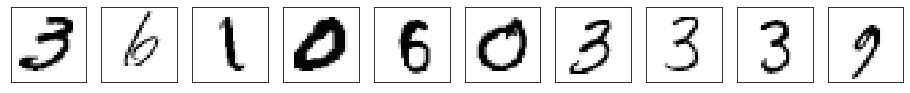

In [3]:
# Fixing the random seed
mx.random.seed(42)

# Gettin the mnist dataset
mnist = mx.test_utils.get_mnist()

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    #axarr[i].axis('off')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()


In [4]:
#setting batch size
batch_size = 100
# creating training and validation set
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

# Dense Autoencoder Model

In [5]:
class Autoencoder(gluon.Block):
    def __init__(self, input_size = 28*28, latent = 10, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        with self.name_scope():
            self.encoder = nn.Sequential() 
            self.encoder.add(nn.Dense(512, activation='relu'))
            self.encoder.add(nn.Dense(128, activation='relu'))
            self.encoder.add(nn.Dense(latent, activation=None))
        
            self.decoder = nn.Sequential()
            self.decoder.add(nn.Dense(128, activation='relu'))
            self.decoder.add(nn.Dense(512, activation='relu'))
            self.decoder.add(nn.Dense( input_size, activation='sigmoid'))
    
    def forward(self, x):
        self.output = self.decoder(self.encoder(x))
        return self.output

In [6]:
# call the model
net = Autoencoder()

In [7]:
# initalise network weights
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
# set optimization algorithm and learning rate
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.0001})

# Train

In [8]:
n_epoch = 50
mse_loss = gluon.loss.L2Loss()
start = time.time()
training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0

    train_data.reset()
    val_data.reset()

    n_batch_train = 0
    for tbatch in train_data:
        n_batch_train +=1
        data = tbatch.data[0].as_in_context(model_ctx)
        with autograd.record():
            y = net(data)
            tloss = mse_loss(y,data)
        tloss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(tloss).asscalar()

    n_batch_val = 0
    for batch in val_data:
        n_batch_val +=1
        vdata = batch.data[0].as_in_context(model_ctx)
        vy = net(vdata)
        vloss = mse_loss(vy,vdata)
        epoch_val_loss += nd.mean(vloss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)


    tqdm.write('Epoch{}, Training loss {:.4f}, Validation loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 0.0323, Validation loss 0.0184
Epoch1, Training loss 0.0159, Validation loss 0.0140
Epoch2, Training loss 0.0133, Validation loss 0.0124
Epoch3, Training loss 0.0122, Validation loss 0.0115
Epoch4, Training loss 0.0115, Validation loss 0.0110
Epoch5, Training loss 0.0110, Validation loss 0.0106
Epoch6, Training loss 0.0106, Validation loss 0.0102
Epoch7, Training loss 0.0102, Validation loss 0.0099
Epoch8, Training loss 0.0100, Validation loss 0.0097
Epoch9, Training loss 0.0097, Validation loss 0.0095
Epoch10, Training loss 0.0095, Validation loss 0.0093
Epoch11, Training loss 0.0093, Validation loss 0.0091
Epoch12, Training loss 0.0092, Validation loss 0.0090
Epoch13, Training loss 0.0090, Validation loss 0.0089
Epoch14, Training loss 0.0089, Validation loss 0.0087
Epoch15, Training loss 0.0088, Validation loss 0.0086
Epoch16, Training loss 0.0087, Validation loss 0.0085
Epoch17, Training loss 0.0085, Validation loss 0.0084
Epoch18, Training loss 0.0084, Validat

In [9]:
model_prefix = "model_dense"
net.save_parameters(model_prefix)

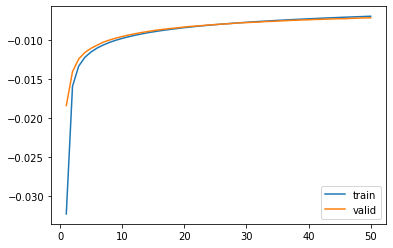

In [10]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

In [11]:
net2 = Autoencoder()
net2.load_parameters(model_prefix, ctx=model_ctx)

# Test and Recontruct Images

In [12]:
val_data.reset()
test_batch = val_data.next()
net2(test_batch.data[0].as_in_context(model_ctx))
result = net2.output.asnumpy()
original = test_batch.data[0].asnumpy()

# Visualize Reconstructed Images

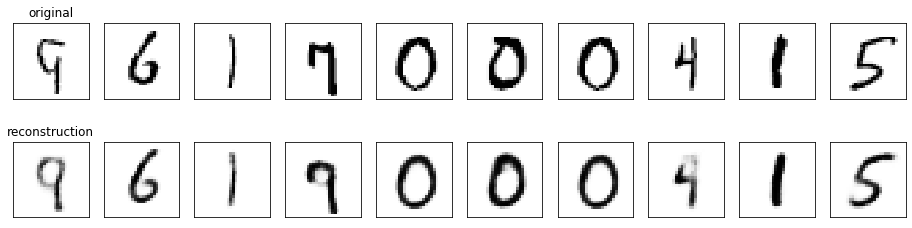

In [13]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

# Sample random images from the latent space

In [14]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples, 10))

In [15]:
images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

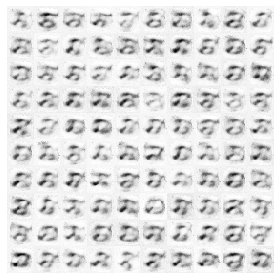

In [16]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()

# Convolutional Autoencoder

In [17]:
class Convolutional_Autoencoder(gluon.Block):
    def __init__(self, **kwargs):
        super(Convolutional_Autoencoder, self).__init__(**kwargs)
        with self.name_scope():
            self.encoder = nn.Sequential() 
            self.encoder.add(nn.Conv2D(channels = 16,kernel_size = 3,strides= 3,padding = 1, activation='relu'))
            self.encoder.add(nn.MaxPool2D(pool_size = 2, strides = 2))
            self.encoder.add(nn.Conv2D(channels = 8,kernel_size = 3,strides= 2,padding = 1, activation='relu'))
            self.encoder.add(nn.MaxPool2D(pool_size = 2, strides = 1))
        
            self.decoder = nn.Sequential()
            self.decoder.add(nn.Conv2DTranspose(channels = 16,kernel_size = 3, strides=2, activation='relu'))
            self.decoder.add(nn.Conv2DTranspose(channels = 8,kernel_size = 5, strides=3, padding=1,activation = 'relu'))
            self.decoder.add(nn.Conv2DTranspose(channels = 1,kernel_size = 2, strides=2, padding=1,activation = 'tanh'))
    
    def forward(self, x):
        self.output = self.decoder(self.encoder(x))
        return self.output

In [18]:
# call the model
conv_net = Convolutional_Autoencoder()

In [19]:
# initalise network weights
conv_net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
# set optimization algorithm and learning rate
trainer = gluon.Trainer(conv_net.collect_params(), 'adam', {'learning_rate': 0.0001})

# Train

In [20]:
n_epoch = 50
mse_loss = gluon.loss.L2Loss()
start = time.time()
training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0

    train_data.reset()
    val_data.reset()

    n_batch_train = 0
    for tbatch in train_data:
        n_batch_train +=1
        data = tbatch.data[0].as_in_context(model_ctx)
        with autograd.record():
            y = conv_net(data)
            tloss = mse_loss(y,data)
        tloss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(tloss).asscalar()

    n_batch_val = 0
    for batch in val_data:
        n_batch_val +=1
        vdata = batch.data[0].as_in_context(model_ctx)
        vy = conv_net(vdata)
        vloss = mse_loss(vy,vdata)
        epoch_val_loss += nd.mean(vloss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)


    tqdm.write('Epoch{}, Training loss {:.4f}, Validation loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 0.0418, Validation loss 0.0335
Epoch1, Training loss 0.0312, Validation loss 0.0293
Epoch2, Training loss 0.0280, Validation loss 0.0268
Epoch3, Training loss 0.0260, Validation loss 0.0251
Epoch4, Training loss 0.0245, Validation loss 0.0237
Epoch5, Training loss 0.0232, Validation loss 0.0226
Epoch6, Training loss 0.0223, Validation loss 0.0217
Epoch7, Training loss 0.0215, Validation loss 0.0210
Epoch8, Training loss 0.0209, Validation loss 0.0204
Epoch9, Training loss 0.0203, Validation loss 0.0199
Epoch10, Training loss 0.0199, Validation loss 0.0194
Epoch11, Training loss 0.0195, Validation loss 0.0191
Epoch12, Training loss 0.0191, Validation loss 0.0187
Epoch13, Training loss 0.0188, Validation loss 0.0184
Epoch14, Training loss 0.0186, Validation loss 0.0181
Epoch15, Training loss 0.0183, Validation loss 0.0179
Epoch16, Training loss 0.0180, Validation loss 0.0177
Epoch17, Training loss 0.0178, Validation loss 0.0174
Epoch18, Training loss 0.0176, Validat

In [21]:
model_prefix = "model_convolutional"
conv_net.save_parameters(model_prefix)

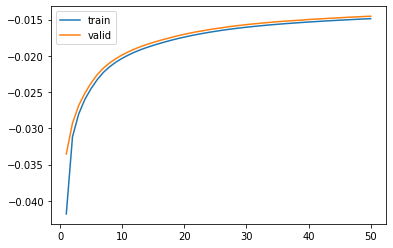

In [22]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

In [23]:
conv_net2 = Convolutional_Autoencoder()
conv_net2.load_parameters(model_prefix, ctx=model_ctx)

# Test and Recontruct Images

In [25]:
val_data.reset()
test_batch = val_data.next()
conv_net2(test_batch.data[0].as_in_context(model_ctx))
result = conv_net2.output.asnumpy()
original = test_batch.data[0].asnumpy()

# Visualize Reconstructed Images

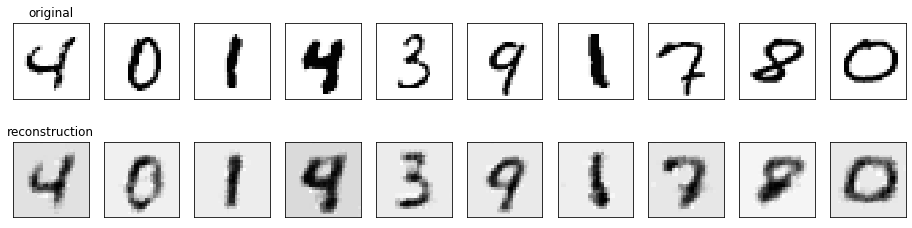

In [26]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

# Sample random images from the latent space

In [37]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples,8, 2,2))

In [38]:
images = conv_net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

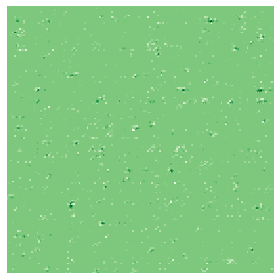

In [43]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))
plt.imshow(canvas, origin="upper", cmap="Greens")
plt.axis('off')
plt.tight_layout()